<a href="https://colab.research.google.com/github/valdolab/DS_mAIstros/blob/main/Week7/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
new_dataset.to_csv('time_series_last4days_sum.csv')

## Using LSTM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(42)

In [ ]:
#change ds for integers numbers
dataset = new_dataset.drop(columns='ds')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

315 105


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(16, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
311/311 - 6s - loss: 0.0207 - 6s/epoch - 19ms/step
Epoch 2/50
311/311 - 1s - loss: 0.0184 - 1s/epoch - 4ms/step
Epoch 3/50
311/311 - 1s - loss: 0.0176 - 927ms/epoch - 3ms/step
Epoch 4/50
311/311 - 1s - loss: 0.0170 - 941ms/epoch - 3ms/step
Epoch 5/50
311/311 - 1s - loss: 0.0167 - 850ms/epoch - 3ms/step
Epoch 6/50
311/311 - 1s - loss: 0.0163 - 583ms/epoch - 2ms/step
Epoch 7/50
311/311 - 1s - loss: 0.0164 - 546ms/epoch - 2ms/step
Epoch 8/50
311/311 - 1s - loss: 0.0162 - 551ms/epoch - 2ms/step
Epoch 9/50
311/311 - 1s - loss: 0.0157 - 562ms/epoch - 2ms/step
Epoch 10/50
311/311 - 1s - loss: 0.0161 - 578ms/epoch - 2ms/step
Epoch 11/50
311/311 - 1s - loss: 0.0158 - 567ms/epoch - 2ms/step
Epoch 12/50
311/311 - 1s - loss: 0.0159 - 566ms/epoch - 2ms/step
Epoch 13/50
311/311 - 1s - loss: 0.0157 - 553ms/epoch - 2ms/step
Epoch 14/50
311/311 - 1s - loss: 0.0158 - 566ms/epoch - 2ms/step
Epoch 15/50
311/311 - 1s - loss: 0.0158 - 566ms/epoch - 2ms/step
Epoch 16/50
311/311 - 1s - loss: 0.0159

In [ ]:
def forecast(model, X, n):

  if(n <= testX.shape[0]):
    #make the n prediction
    X_input = X[0:n]

  else:
    #make the recursive predictions to n
    X_input = X
    lasts_features = testX[testX.shape[0]-1:testX.shape[0]]
    look_forward = n - X.shape[0]
    for i in range(look_forward):
      one_pre = model.predict(lasts_features)
      one_pre = one_pre[0][0]
      #create new feature and concat
      olds = testX[-1][0][1:lasts_features.shape[2]]
      news = np.concatenate((olds, [one_pre]))
      X_input = np.concatenate((X_input, [[news]]))

  Predictions = model.predict(X_input)

  return Predictions, X_input

In [ ]:
# make predictions training
trainPredict = model.predict(trainX)
#make forcasting
#testPredict = model.predict(testX)
testPredict, xinputs = forecast(model,testX,30)

# invert predictions, reverse normalization
trainPredict_ = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])
testPredict_ = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])

1/1 [==============================] - 0s 21ms/step


In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY_[0], trainPredict_[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY_[0][0:30], testPredict_[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# print('Test Score SMAPE: ', smape(testY_[0],testPredict[:,0]))
# from sklearn.metrics import mean_absolute_error
# mape = mean_absolute_error(testY[0], testPredict[:,0])
# print('Test Score MAPE: ', mape)

Train Score: 53.78 RMSE
Test Score: 13.62 RMSE


In [ ]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_)+look_back, :] = trainPredict_
# shift test predictions for plotting
#testPredictPlot = np.empty_like(dataset)

size_testP = testPredict_.shape[0]

dis1 = len(trainPredict_)+(look_back*2)+1
dis2 = (len(trainPredict_)+(look_back*2)+1)+size_testP

testPredictPlot = np.empty((dis2,1,))
testPredictPlot[:, :] = np.nan

testPredictPlot[dis1:dis2,:] = testPredict_

In [ ]:
true_testPredict = np.empty_like(dataset)
true_testPredict[:, :] = np.nan
true_testPredict[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testY_.T

In [ ]:
testY.shape

(1, 101)

4/4 [==============================] - 0s 3ms/step


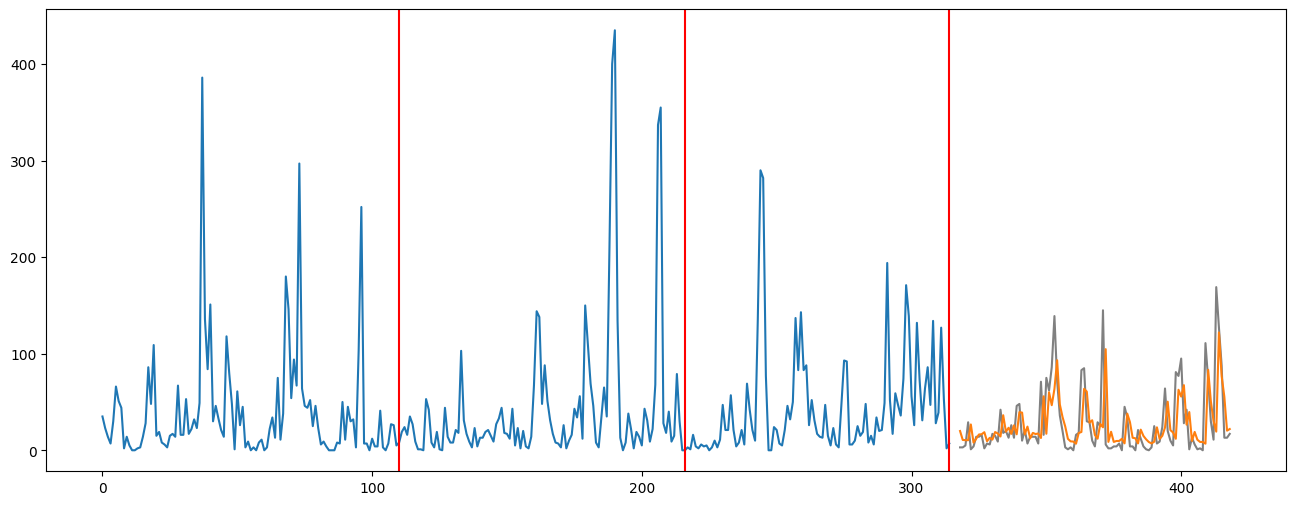

In [ ]:
# make predictions training
trainPredict = model.predict(trainX)
#make forcasting
#testPredict = model.predict(testX)
testPredict, xinputs = forecast(model,testX,101)

# invert predictions, reverse normalization
trainPredict_ = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])
testPredict_ = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_)+look_back, :] = trainPredict_
# shift test predictions for plotting
#testPredictPlot = np.empty_like(dataset)

size_testP = testPredict_.shape[0]

dis1 = len(trainPredict_)+(look_back*2)+1
dis2 = (len(trainPredict_)+(look_back*2)+1)+size_testP

testPredictPlot = np.empty((dis2,1,))
testPredictPlot[:, :] = np.nan
testPredictPlot[dis1:dis2,:] = testPredict_

true_testPredict = np.empty_like(dataset)
true_testPredict[:, :] = np.nan
true_testPredict[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testY_.T

# plot baseline and predictions
plt.figure(figsize=(16,6))
plt.plot(scaler.inverse_transform(train))
#plt.plot(trainPredictPlot)
#just 30: true_testPredict[:len(trainPredict)+(look_back*2)+31]
plt.plot(true_testPredict, color='gray')
plt.plot(testPredictPlot)
plt.axvline(x=110, color='red')
plt.axvline(x=216, color='red')
plt.axvline(x=314, color='red')
plt.show()